In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit.circuit.library.standard_gates import XGate
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler, Session

In [2]:
# This notebook uses the IBM Quantum Account for running Qiskit Runtime. Using the Quantum Channel 
# is free except that you have access only to simulators and some quantum computers (not all).
# You can view the resources you have access to here: https://quantum-computing.ibm.com/services/resources?tab=yours

In [85]:
# Your token can be found here: https://quantum-computing.ibm.com/
API_TOKEN = "?"

In [86]:
# Save IBM Quantum account credentials locally in $HOME/.qiskit/qiskit-ibm.json (you'll need to run this only once!). 
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=API_TOKEN, overwrite=True)

In [3]:
# Load a previously saved account and optionally select a 
# different hub/group/project in case you have access
provider = IBMProvider(instance="ibm-q/open/main")

In [4]:
# Create a quantum circuit
cr = ClassicalRegister(5)
qr = QuantumRegister(5)
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.id(qr[1])
qc.h(qr[2])
qc.id(qr[3])
qc.t(qr[4])

qc.append(XGate().control(num_ctrl_qubits=1, ctrl_state='1'), [qr[0], qr[1]])
qc.append(XGate().control(num_ctrl_qubits=1, ctrl_state='1'), [qr[2], qr[3]])

# Circuit optimizations, if any, are 
# not applied beyond the barrier
qc.barrier()

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)
qc.measure(3, 3)
qc.measure(4, 4)

# Visualize the quantum circuit
qc.draw()

┌───┐      ░ ┌─┐            
q0_0: ┤ H ├──■───░─┤M├────────────
      ├───┤┌─┴─┐ ░ └╥┘┌─┐         
q0_1: ┤ I ├┤ X ├─░──╫─┤M├─────────
      ├───┤└───┘ ░  ║ └╥┘┌─┐      
q0_2: ┤ H ├──■───░──╫──╫─┤M├──────
      ├───┤┌─┴─┐ ░  ║  ║ └╥┘┌─┐   
q0_3: ┤ I ├┤ X ├─░──╫──╫──╫─┤M├───
      ├───┤└───┘ ░  ║  ║  ║ └╥┘┌─┐
q0_4: ┤ T ├──────░──╫──╫──╫──╫─┤M├
      └───┘      ░  ║  ║  ║  ║ └╥┘
c0: 5/══════════════╩══╩══╩══╩══╩═
                    0  1  2  3  4

In [5]:
# Select quantum device to run on. Select simulator -> True if you want to run on a simulator which is faster
# INSPECT DEVICES YOU HAVE ACCESS TO HERE: https://quantum-computing.ibm.com/services/resources?tab=yours
backends = provider.backends(filters=lambda x: x.configuration().n_qubits >= (len(qc.qubits)) \
    and (x.configuration().simulator == True) and (x.status().operational))
backend = least_busy(backends)
print("Selected the least busy backend: ", backend.name)

Selected the least busy backend:  ibmq_qasm_simulator


In [6]:
# Qiskit Runtime: is a programming model and containerized environment for deploying quantum programs, designed to reduce the 
# computational cycle time between quantum and classical computers. For details please checkout following resources
# https://medium.com/qiskit/so-what-is-qiskit-runtime-anyway-c78aecf3742
# https://qiskit.org/ecosystem/ibm-runtime/
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend(backend.name)

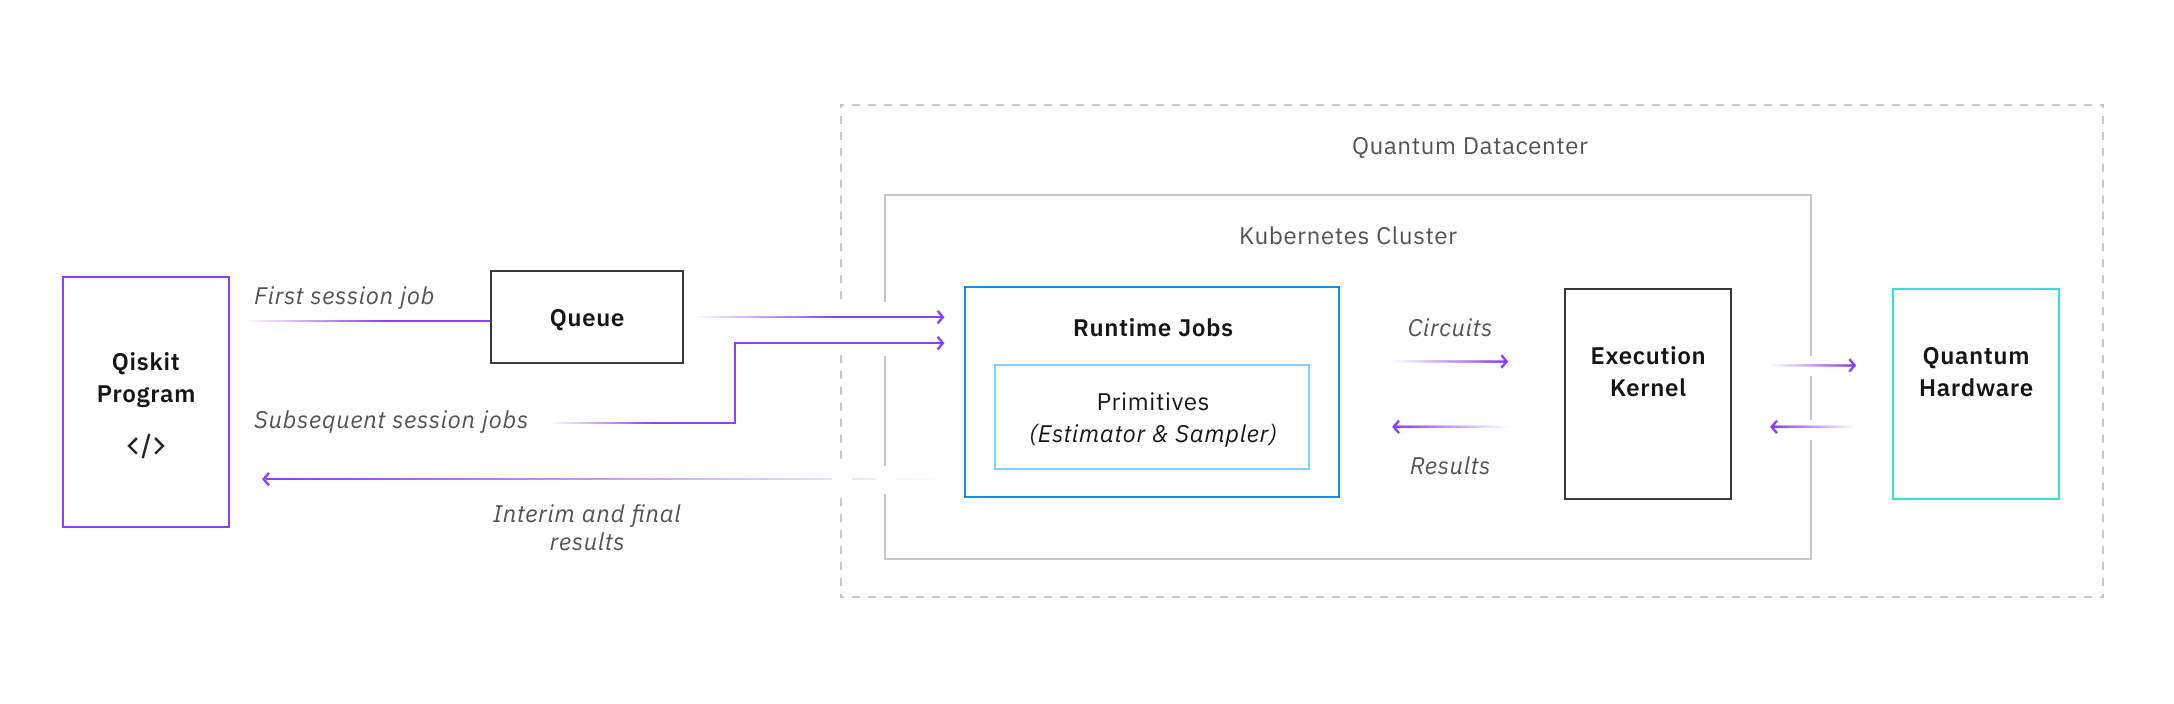

In [7]:
# initializing an instance of qiskit_ibm_runtime.Sampler rather than 
# qiskit.primitives.Sampler to use Qiskit Runtime’s implementation of the Sampler
options = Options(environment={"log_level": "INFO"})
# optimization_level=3 adds dynamical decoupling
options.optimization_level=3
# resilience_level=1 adds readout error mitigation
options.resilience_level=1
options.execution.shots = 100

In [8]:
with Session(backend=backend, max_time="10s"):
    sampler = Sampler(options=options)
    try:
        job = sampler.run(qc)
    except Exception as ex:
        print(ex.message)

In [9]:
# Verify job status 
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [10]:
# INSPECT YOUR JOBS HERE: https://quantum-computing.ibm.com/jobs

In [11]:
result = job.result()
print(f">>> {result}")
print(f"  > Quasi-probability distribution: {result.quasi_dists[0]}")
print(f"  > Metadata: {result.metadata[0]}")

>>> SamplerResult(quasi_dists=[{0: 0.29, 3: 0.25, 12: 0.27, 15: 0.19}], metadata=[{'shots': 100, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.021871613003895618}])
  > Quasi-probability distribution: {0: 0.29, 3: 0.25, 12: 0.27, 15: 0.19}
  > Metadata: {'shots': 100, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.021871613003895618}


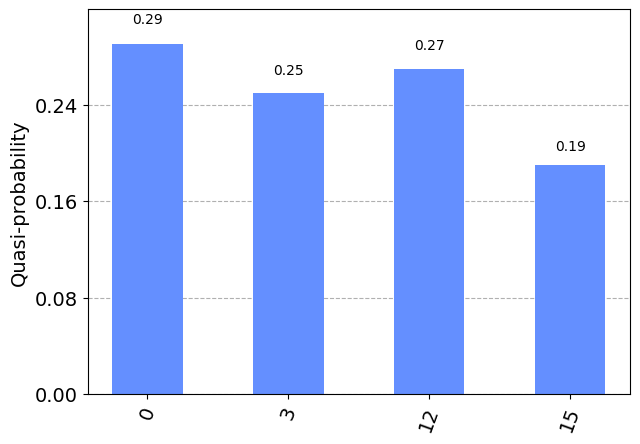

In [12]:
plot_histogram(result.quasi_dists)

In [13]:
from qiskit.tools.jupyter import *

%qiskit_version_table